Dataset link:
https://www.kaggle.com/datasets/gpiosenka/100-bird-species?resource=download



In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import imageio.v2 as imageio

In [2]:
data_path = 'data'
test_data = f'{data_path}/test'
train_data = f'{data_path}/train'
validate_data = f'{data_path}/valid'

In [3]:
class BirdDataLoader(object):
    def __init__(self, test_data, train_data, validate_data):
        self.test_data = test_data
        self.train_data = train_data
        self.validate_data = validate_data
        self.birds = []

    def read_images_labels(self, path):
        labels = []
        images = []
        self.birds = sorted(os.listdir(path))
        for i, bird in enumerate(self.birds):
            for image in os.listdir(os.path.join(path, bird)):
                img_path = os.path.join(path, bird, image)
                img = imageio.imread(img_path)
                labels.append(i)
                images.append(img)

        return np.array(images), np.array(labels)

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.train_data)
        x_test, y_test = self.read_images_labels(self.test_data)
        return (x_train, y_train), (x_test, y_test)

In [4]:
print('Loading Bird dataset...')
bird_dataloader = BirdDataLoader(test_data, train_data, validate_data)
(x_train, y_train), (x_test, y_test) = bird_dataloader.load_data()
num_classes = len(bird_dataloader.birds)
print(f"Number of classes: {num_classes}")
print(f"classes: {bird_dataloader.birds}")
train_size = len(x_train)
test_size = len(x_test)
print('Bird dataset loaded.')
print(f'{train_size} training images')
print(f'{test_size} testing images')

Loading Bird dataset...
Number of classes: 10
classes: ['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'AFRICAN PIED HORNBILL', 'AFRICAN PYGMY GOOSE', 'ALBATROSS']
Bird dataset loaded.
1601 training images
50 testing images


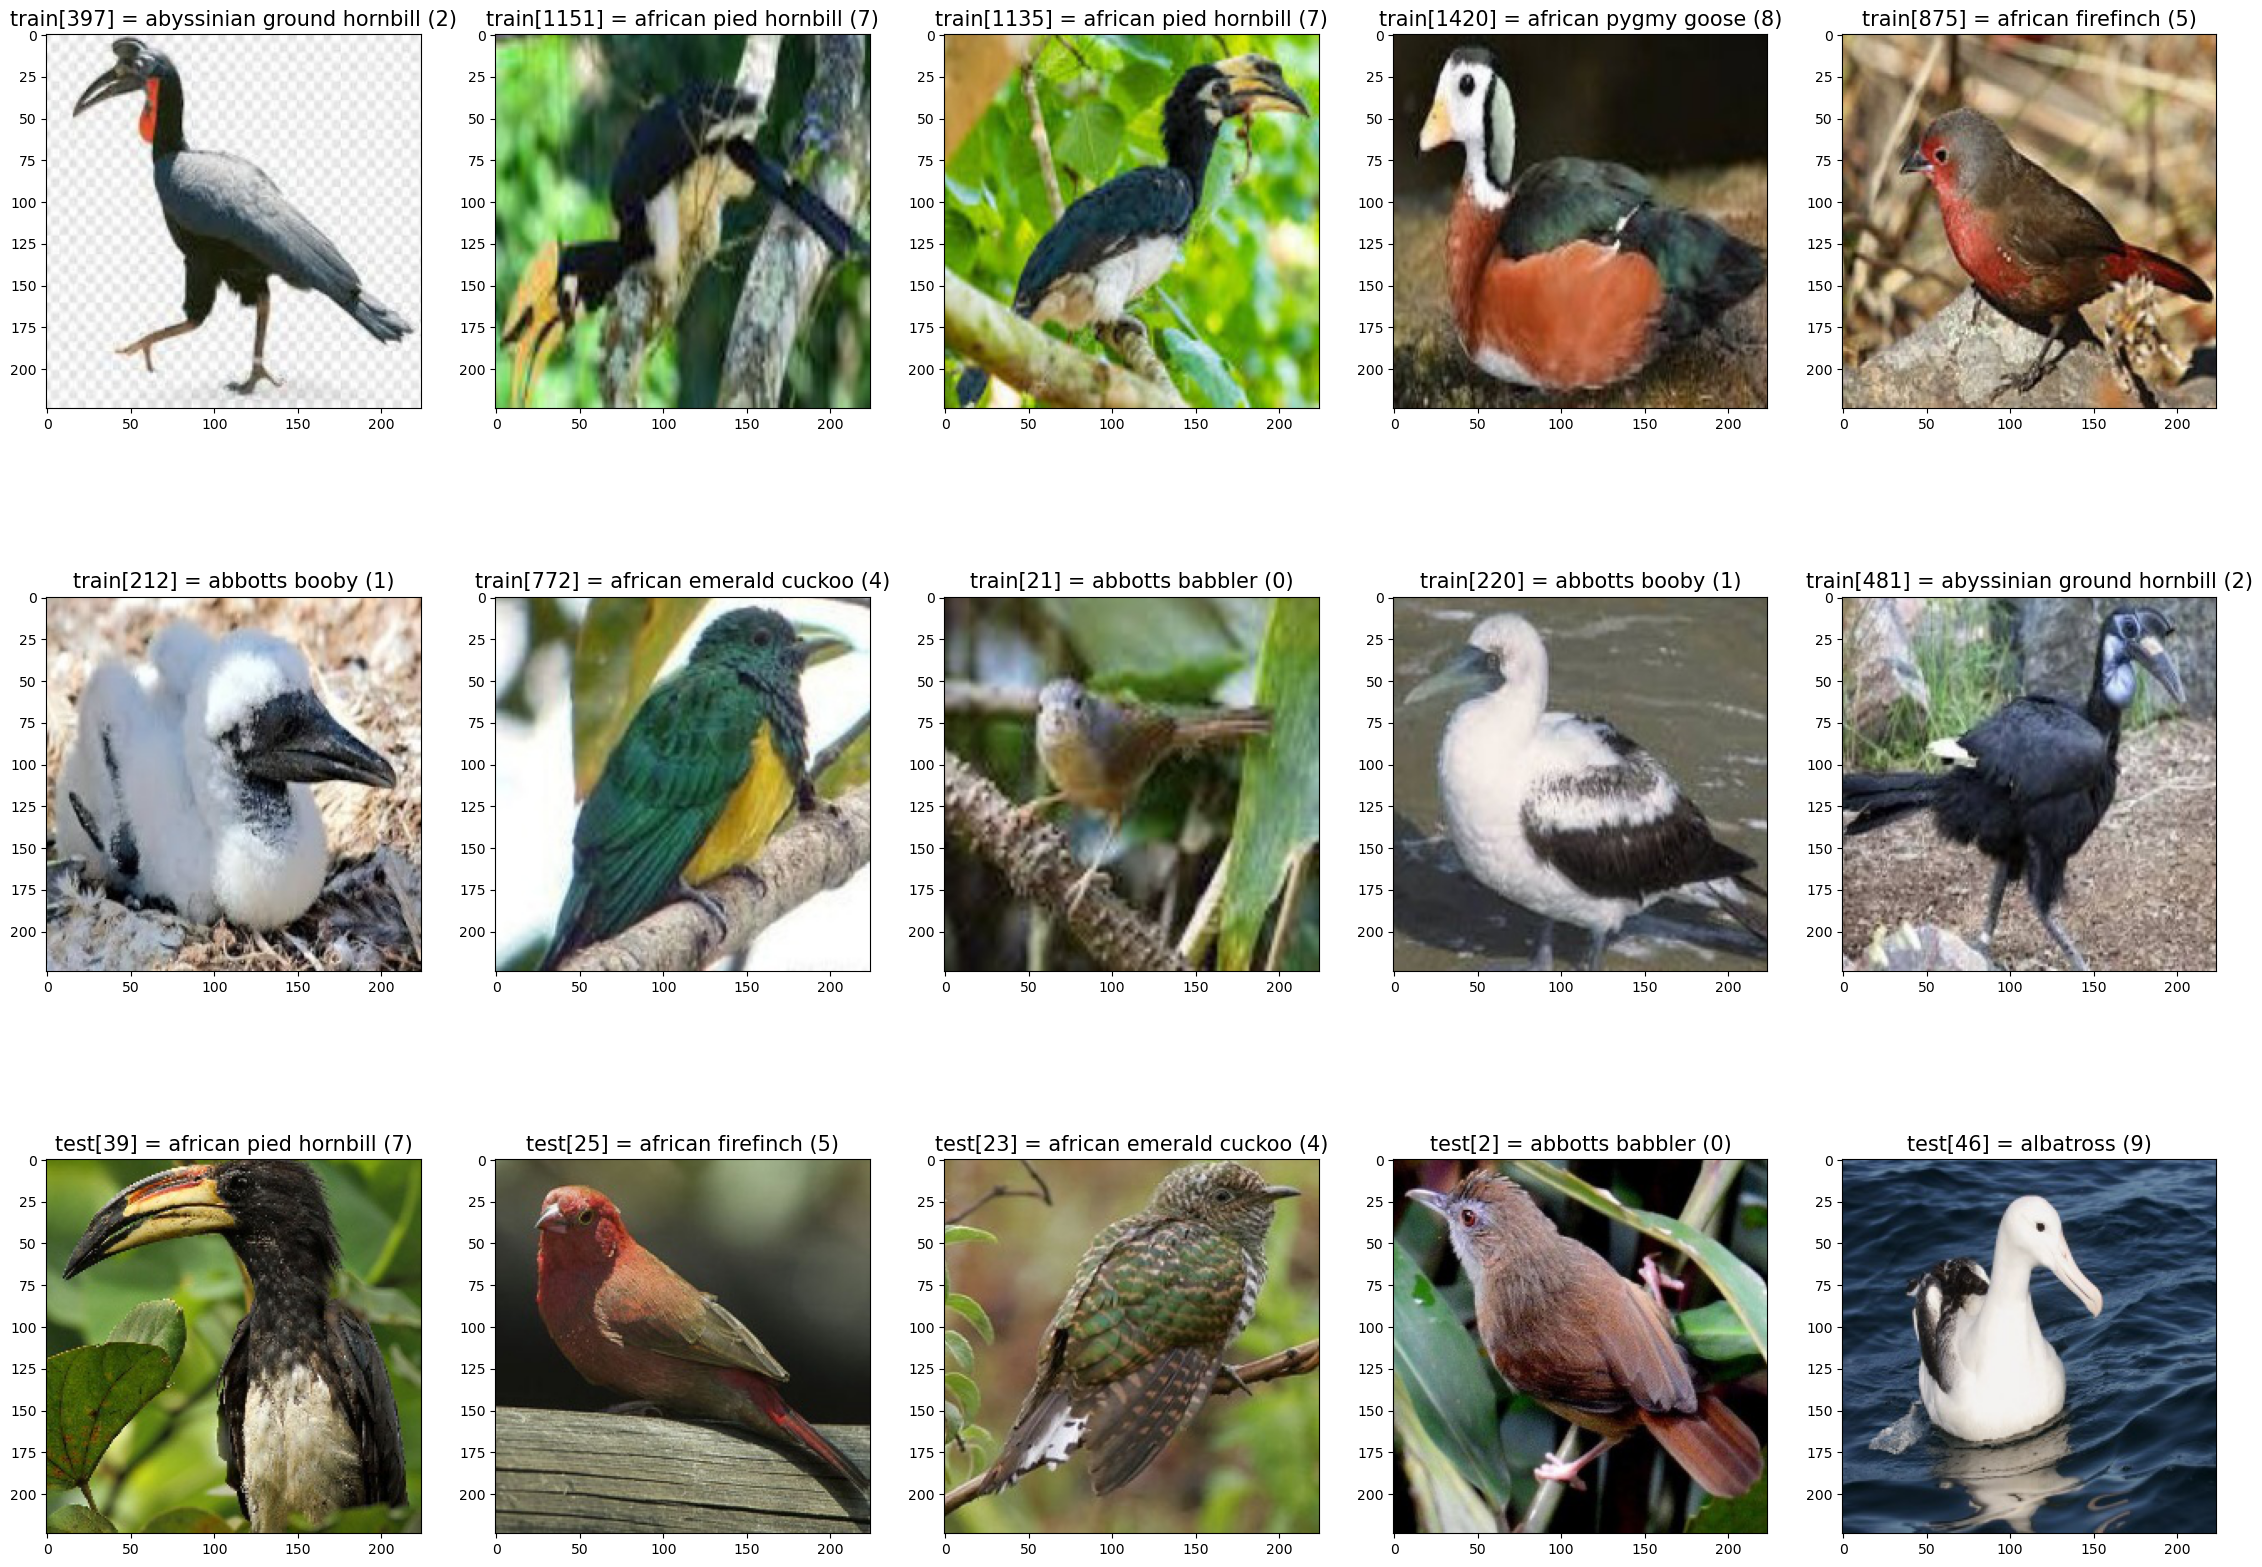

In [5]:
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images) / cols) + 1
    plt.figure(figsize=(28, 28))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize=15)
        index += 1


random_images = []
for i in range(0, 10):
    r = random.randint(1, train_size - 1)
    random_images.append((x_train[r], f'train[{r}] = {bird_dataloader.birds[y_train[r]].lower()} ({y_train[r]})'))
for i in range(0, 5):
    r = random.randint(1, test_size - 1)
    random_images.append((x_test[r], f'test[{r}] = {bird_dataloader.birds[y_test[r]].lower()} ({y_test[r]})'))

show_images(list(map(lambda x: x[0], random_images)), list(map(lambda x: x[1], random_images)))

In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [7]:
# Convert data to PyTorch tensors
channel_first_x_train = np.moveaxis(x_train, -1, 1)  # move channels to come first
channel_first_x_test = np.moveaxis(x_test, -1, 1)  # move channels to come first
print(f'x train shape: {channel_first_x_train.shape}')
print(f'x test shape: {channel_first_x_test.shape}')

train_images_tensor = torch.tensor(channel_first_x_train, dtype=torch.float) / 255.0  # Normalize
train_labels_tensor = torch.tensor(y_train, dtype=torch.long)
test_images_tensor = torch.tensor(channel_first_x_test, dtype=torch.float) / 255.0  # Normalize
test_labels_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

x train shape: (1601, 3, 224, 224)
x test shape: (50, 3, 224, 224)


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class SmallResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=num_classes):
        super(SmallResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.linear = nn.Linear(128 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [9]:
model = SmallResNet(BasicBlock, [2, 2])

if torch.backends.mps.is_available():
    print("mps is available")
    device = torch.device("mps")
elif torch.cuda.is_available():
    print("cuda is available")
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"running on device: {device}")

model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
epochs = 1 * 60 * 1 # each epoch takes about 30s so 2 epochs is 1 minute
iterations = epochs * len(train_loader)
print_step = iterations // 100
iterations_str_len = len(str(iterations))
iteration = 1
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if iteration % print_step == 0 or iteration == iterations:
            print(
                f'iteration: [{iteration:{iterations_str_len}}/{iterations:{iterations_str_len}}]\t loss: {loss.item():.6f}')
        iteration += 1
print('Training done')
# Testing loop - Calculate accuracy
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy of the model on the test images: {accuracy * 100:.2f}%')
filename = f'{int(accuracy*100)}-model.pt'
torch.save(model.state_dict(), filename)
print(f'saved model to {filename}')

cuda is available
running on device: cuda
iteration: [  120/12060]	 loss: 2.507781
iteration: [  240/12060]	 loss: 2.060616
iteration: [  360/12060]	 loss: 1.389707
iteration: [  480/12060]	 loss: 2.096855
iteration: [  600/12060]	 loss: 1.550808
iteration: [  720/12060]	 loss: 1.491570
iteration: [  840/12060]	 loss: 1.319871
iteration: [  960/12060]	 loss: 1.108433
iteration: [ 1080/12060]	 loss: 1.327480
iteration: [ 1200/12060]	 loss: 2.077036
iteration: [ 1320/12060]	 loss: 1.155912
iteration: [ 1440/12060]	 loss: 0.954537
iteration: [ 1560/12060]	 loss: 1.878334
iteration: [ 1680/12060]	 loss: 1.246749
iteration: [ 1800/12060]	 loss: 0.733621
iteration: [ 1920/12060]	 loss: 2.149459
iteration: [ 2040/12060]	 loss: 1.283152
iteration: [ 2160/12060]	 loss: 2.574303
iteration: [ 2280/12060]	 loss: 0.907984
iteration: [ 2400/12060]	 loss: 1.128065
iteration: [ 2520/12060]	 loss: 0.932386
iteration: [ 2640/12060]	 loss: 1.202469
iteration: [ 2760/12060]	 loss: 1.405085
iteration: [ 28